# Exploratory Data Analysis

In [1]:
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

import sagemaker
from sagemaker import get_execution_role
import boto3

## Sagemaker Resources and S3 Data

In [2]:
sagemaker_session = sagemaker.Session()
sagemaker_session

In [3]:
role = sagemaker.get_execution_role()
role

'arn:aws:iam::906713186745:role/service-role/AmazonSageMaker-ExecutionRole-20210419T071573'

In [4]:
bucket = sagemaker_session.default_bucket()
bucket

'sagemaker-us-east-1-906713186745'

In [5]:
def get_s3_uri(prefix, bucket=bucket):
    return "s3://{}/{}".format(bucket, prefix)

In [6]:
genes = pd.read_csv(get_s3_uri("assets/processed_data/genes.csv"), index_col=0)
genes.shape

(999, 20531)

In [7]:
clinical = pd.read_csv(get_s3_uri("assets/processed_data/clinical.csv"))
clinical.shape

(999, 15)

In [8]:
all(genes.index == clinical['Sample ID'])

True

In [9]:
genesWithNan = genes.columns[genes.isna().any()].tolist()
len(genesWithNan)

319

In [10]:
genes = genes.dropna(axis=1)
genes.shape

(999, 20212)

## Dimensionality Reduction with sklearn native

In [16]:
def plot_dimred(X_r, y, title, labels=[0,1],
                target_names=["Other","Triple Neg."], colors=['navy','darkorange']):
    plt.figure(dpi=100)

    for color, label, target_name in zip(colors, labels, target_names):
        plt.scatter(
            X_r[y == label, 0], 
            X_r[y == label, 1], 
            color=color,
            label=target_name
        )

    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")

    plt.show()

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(genes)

PCA(n_components=2)

In [35]:
X_pca = pca.transform(genes)

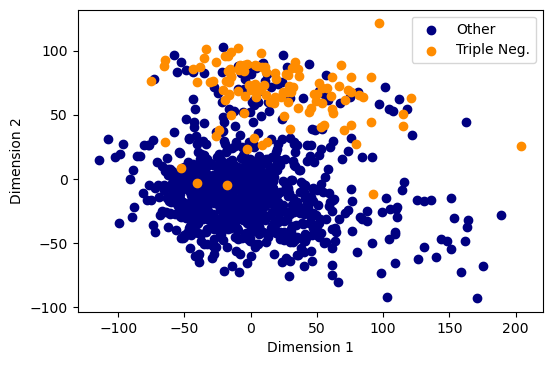

In [18]:
plot_dimred(X_pca, clinical["Label"].values ,"PCA")

In [32]:
kmeans = KMeans(init="k-means++", n_clusters=2)
kmeans.fit(genes)

KMeans(n_clusters=2)

In [34]:
y_km = kmeans.predict(genes)

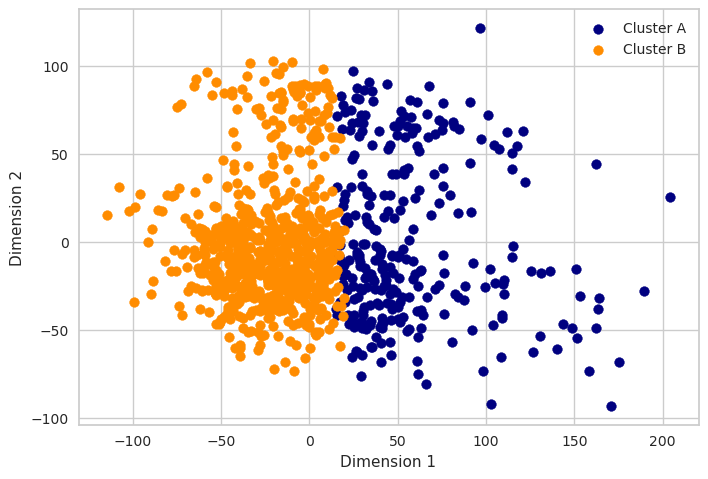

In [36]:
plot_dimred(X_pca, y_km ,target_names=["Cluster A","Cluster B"])

In [41]:
pd.crosstab(clinical["Label"].values, y_km)

col_0,0,1
row_0,,
0.0,232,652
1.0,53,62


## PCA with Sagemaker

Reduce dimensionality to 2 for visualizing _discernible_ patterns, if any

In [ ]:
# location for model artifacts
path_pca_artifacts = get_s3_uri("assets/model_artifacts")
path_pca_artifacts

In [ ]:
from sagemaker import PCA

pca_sm = PCA(
    role = role,
    train_instance_count = 1,
    train_instance_type = 'ml.c4.xlarge',
    output_path = path_pca_artifacts,
    num_components = 2, 
    sagemaker_session = sagemaker_session
)
pca_sm

In [ ]:
## convert to RecordSet format
train_data_np = genes.values.astype('float32')
formatted_train_data = pca_sm.record_set(train_data_np)

In [ ]:
pca_sm.fit(formatted_train_data)

In [ ]:
training_job_name = 'pca-2021-04-24-22-49-54-169' #Sagemaker conole -> Training jobs

# where the model is saved, by default
model_key = os.path.join("assets/model_artifacts", training_job_name, 'output/model.tar.gz')
model_key

In [ ]:
# download and unzip model
boto3.resource('s3').Bucket(bucket).download_file(model_key, 'model.tar.gz')

# unzipping as model_algo-1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

## Relationship between Class Label and Age

In [42]:
clinical.columns

Index(['Unnamed: 0', 'Sample ID', 'Sample Type', 'Fraction Genome Altered',
       'Diagnosis Age', 'Sex', 'Race Category', 'Ethnicity Category',
       'Informed consent verified', 'ER Status By IHC', 'PR status by ihc',
       'IHC-HER2', 'RaceWhite', 'Label', 'num_receptor_missing'],
      dtype='object')

<AxesSubplot:title={'center':'Fraction Genome Altered'}, xlabel='Label'>

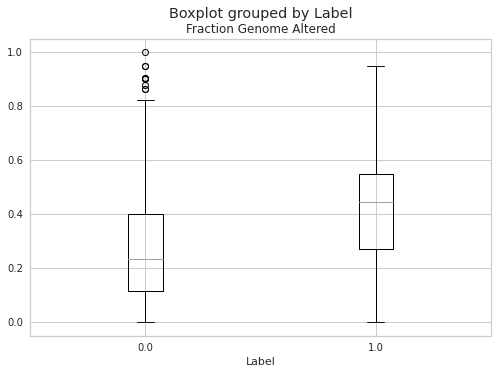

In [47]:
clinical.boxplot(column=['Fraction Genome Altered'], by="Label")

In [52]:
clinical.loc[clinical.Label==1, "Fraction Genome Altered"].to_list()

[0.4163,
 0.3918,
 0.6677,
 0.3928,
 0.7061,
 0.5025,
 0.3822,
 0.4533,
 0.9463,
 0.7809999999999999,
 0.0001,
 0.4752,
 0.555,
 0.1367,
 0.7563,
 0.249,
 0.7743,
 0.6645,
 0.5937,
 0.4614,
 nan,
 0.3136,
 0.5152,
 0.1791,
 0.5065,
 0.4092,
 0.1854,
 0.1742,
 0.2899,
 0.3686,
 0.4407,
 0.5378,
 0.4552,
 nan,
 0.4834,
 0.001,
 0.4434,
 0.4668,
 0.631,
 0.7327,
 0.1548,
 0.3991,
 0.6214,
 0.4509,
 0.3431,
 0.0895,
 nan,
 0.4452,
 0.4696,
 0.5101,
 0.6832,
 0.4915,
 0.0004,
 0.0451,
 0.3384,
 0.5552,
 0.2146,
 0.307,
 0.4262,
 0.3435,
 0.6731,
 0.095,
 0.606,
 0.071,
 0.7015,
 0.3453,
 0.5787,
 0.4675,
 0.0,
 0.0027,
 0.2303,
 0.5135,
 0.3564,
 0.588,
 0.7389,
 0.1781,
 0.4986,
 0.5356,
 0.5742,
 0.414,
 0.3656,
 0.6388,
 0.3387,
 0.6698,
 0.4824,
 0.2982,
 0.0848,
 0.7127,
 0.332,
 0.6709999999999999,
 0.4764,
 0.4586,
 0.1889,
 0.3672,
 nan,
 0.3713,
 0.3884,
 0.4637,
 0.4697,
 0.9462,
 0.1579,
 0.4664,
 0.4676,
 0.2153,
 0.5638,
 0.2286,
 0.1934,
 0.2932,
 0.9228,
 0.1771,
 0.057,
 0.2

In [50]:
from scipy import stats

stats.ttest_ind(clinical.loc[clinical.Label==1, "Fraction Genome Altered"].to_list(),
                clinical.loc[clinical.Label==0, "Fraction Genome Altered"])

Ttest_indResult(statistic=nan, pvalue=nan)

<AxesSubplot:title={'center':'Diagnosis Age'}, xlabel='Label'>

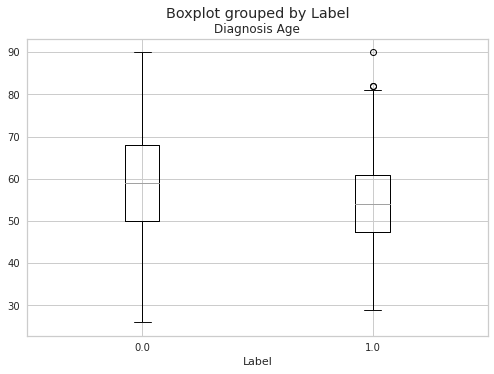

In [49]:
clinical.boxplot(column=['Diagnosis Age'], by="Label")